# Extra Business Analyses - Visualizations

Three bonus analyses beyond the required questions:
1. **Gross Margin by Category** - Which categories are most profitable?
2. **Customer Retention** - One-time vs. repeat customer analysis
3. **Lead Time Distribution** - How lead times differ between Online and Store channels

In [1]:
from pyspark.sql import SparkSession
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# Configure pandas display
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

In [2]:
# Initialize Spark
spark = (
    SparkSession.builder
    .appName("extra_analysis_visuals")
    .master("local[*]")
    .config("spark.sql.shuffle.partitions", "4")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

# Path to publish layer (Gold) - dynamic lookup
from pathlib import Path
from pyspark.sql import functions as F

CWD = Path.cwd().resolve()
if CWD.name == 'notebooks':
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

publish_candidates = [
    PROJECT_ROOT / 'out' / 'publish(gold)',
    PROJECT_ROOT / 'out' / 'publish'
]
for candidate in publish_candidates:
    if candidate.exists():
        publish_path = candidate
        break
else:
    raise FileNotFoundError('Publish directory not found.')

print(f"Reading from: {publish_path.resolve()}")

# Load DW tables (fact and dimensions)
print("\nLoading data warehouse tables...")
fact_sales = spark.read.parquet(str(publish_path / "fact_sales"))
dim_product = spark.read.parquet(str(publish_path / "dim_product"))
dim_customer = spark.read.parquet(str(publish_path / "dim_customer"))

print(f"Loaded fact_sales: {fact_sales.count():,} rows")
print(f"Loaded dim_product: {dim_product.count():,} products")
print(f"Loaded dim_customer: {dim_customer.count():,} customers")

Reading from: C:\Users\Andre\Desktop\upstart13_pipeline\out\publish(gold)

Loading data warehouse tables...
Loaded fact_sales: 121,317 rows
Loaded dim_product: 295 products
Loaded dim_customer: 19,119 customers


## 1. Gross Margin by Category

Shows which product categories generate the most revenue and have the highest profit margins.

In [3]:
# Calculate Gross Margin by Category from DW
margin_df = (
    fact_sales.alias('f')
    .join(
        dim_product.select('product_key', 'product_category').alias('p'),
        F.col('f.product_key') == F.col('p.product_key'),
        'left'
    )
    .groupBy('p.product_category')
    .agg(
        F.sum('f.line_total').alias('TotalRevenue'),
        F.sum('f.standard_cost_total').alias('TotalCost')
    )
    .withColumn('TotalGrossProfit', F.col('TotalRevenue') - F.col('TotalCost'))
    .withColumn('GrossMarginPct', (F.col('TotalGrossProfit') / F.col('TotalRevenue')) * 100)
    .withColumnRenamed('product_category', 'ProductCategoryName')
    .orderBy(F.desc('TotalRevenue'))
)

margin_pd = margin_df.toPandas()

print("Gross Margin by Category:")
print(margin_pd.to_string(index=False))
print(f"\nTotal categories: {len(margin_pd)}")

Gross Margin by Category:
ProductCategoryName  TotalRevenue     TotalCost  TotalGrossProfit  GrossMarginPct
              Bikes 94,651,172.70 86,714,778.69      7,936,394.02            8.38
         Components 11,575,014.86 11,135,393.88        439,620.99            3.80
           Clothing  2,120,525.42  1,811,650.17        308,875.26           14.57
        Accessories  1,357,975.83    812,618.68        545,357.16           40.16

Total categories: 4


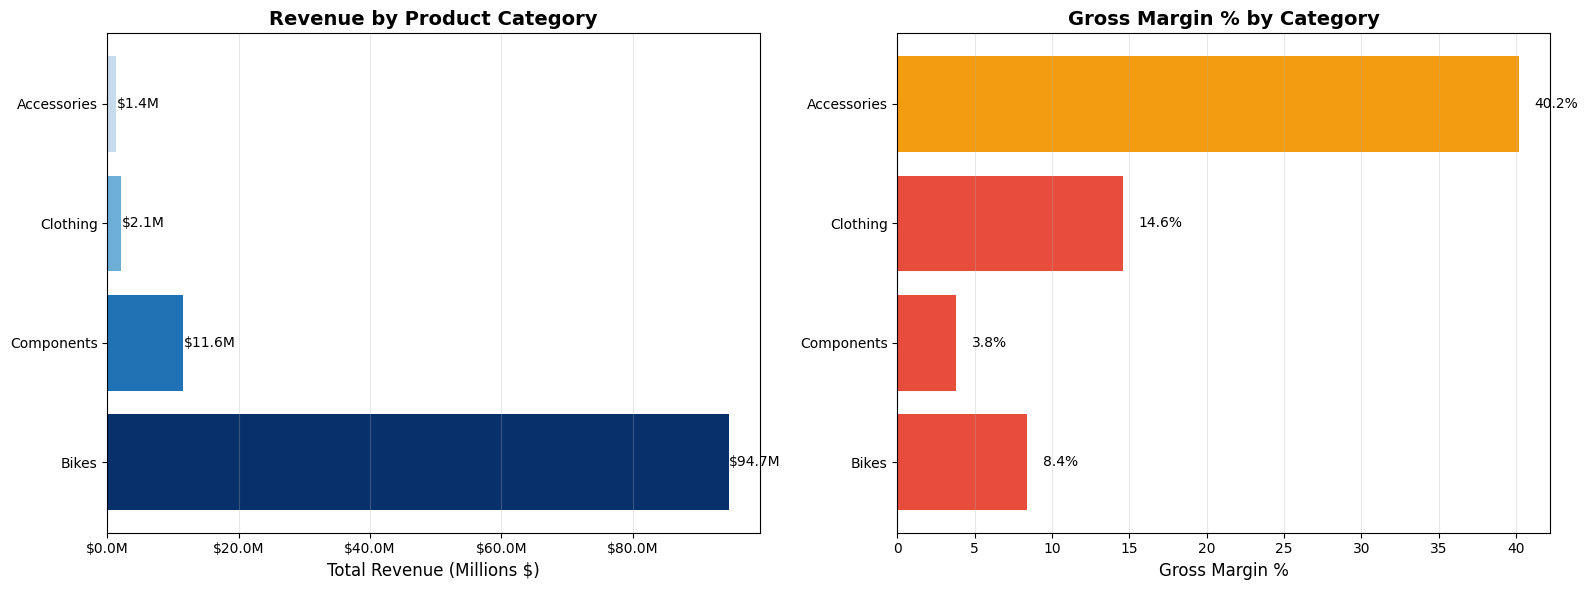


=== KEY INSIGHTS ===
Highest Revenue: Bikes ($94,651,173)
Highest Margin: Accessories (40.2%)

Average Margin across all categories: 16.7%


In [5]:
# Visualize revenue and margin
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Revenue by category - use matplotlib colormap instead of seaborn
n_categories = len(margin_pd)
colors_revenue = plt.cm.Blues_r(range(0, 256, 256 // n_categories))[:n_categories]

# Revenue bar chart
bars = ax1.barh(margin_pd['ProductCategoryName'], margin_pd['TotalRevenue'] / 1_000_000, color=colors_revenue)
ax1.set_xlabel('Total Revenue (Millions $)', fontsize=12)
ax1.set_title('Revenue by Product Category', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.1f}M'))

# Add revenue labels
for i, bar in enumerate(bars):
    revenue = margin_pd['TotalRevenue'].iloc[i] / 1_000_000  # in millions
    ax1.text(
        bar.get_width() + 0.05,  # position just after the bar
        bar.get_y() + bar.get_height() / 2,  # vertical alignment
        f'${revenue:,.1f}M',  # revenue in millions
        va='center', fontsize=10, color='black'
    )

# Margin percentage by category
colors_margin = ['#2ecc71' if x > 50 else '#f39c12' if x > 30 else '#e74c3c' 
                 for x in margin_pd['GrossMarginPct']]
ax2.barh(margin_pd['ProductCategoryName'], margin_pd['GrossMarginPct'], color=colors_margin)
ax2.set_xlabel('Gross Margin %', fontsize=12)
ax2.set_title('Gross Margin % by Category', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add margin percentage labels
for i, (cat, pct) in enumerate(zip(margin_pd['ProductCategoryName'], margin_pd['GrossMarginPct'])):
    ax2.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Key insights
top_revenue = margin_pd.iloc[0]
top_margin = margin_pd.loc[margin_pd['GrossMarginPct'].idxmax()]

print("\n=== KEY INSIGHTS ===")
print(f"Highest Revenue: {top_revenue['ProductCategoryName']} (${top_revenue['TotalRevenue']:,.0f})")
print(f"Highest Margin: {top_margin['ProductCategoryName']} ({top_margin['GrossMarginPct']:.1f}%)")
print(f"\nAverage Margin across all categories: {margin_pd['GrossMarginPct'].mean():.1f}%")


## 2. Customer Retention Analysis

Understanding customer loyalty - how many customers make repeat purchases?

In [6]:
# Calculate Customer Retention from DW
customer_metrics = (
    fact_sales
    .groupBy('customer_key')
    .agg(
        F.countDistinct('sales_order_id').alias('TotalOrders'),
        F.sum('line_total').alias('TotalRevenue')
    )
)

# Join with customer dimension
customer_metrics = customer_metrics.join(
    dim_customer.select('customer_key', 'customer_segment'), 
    on='customer_key', 
    how='left'
)

# Classify customers as One-time or Repeat
customer_metrics = customer_metrics.withColumn(
    'CustomerType',
    F.when(F.col('TotalOrders') <= 1, 'One-time').otherwise('Repeat')
)

# Aggregate by customer type
retention_summary_df = (
    customer_metrics
    .groupBy('CustomerType')
    .agg(
        F.count('customer_key').alias('CustomerCount'),
        F.avg('TotalOrders').alias('AvgOrders'),
        F.avg('TotalRevenue').alias('AvgRevenue'),
        F.sum('TotalRevenue').alias('TotalRevenue')
    )
)

# Calculate retention metrics
totals = retention_summary_df.agg(
    F.sum('CustomerCount').alias('TotalCustomers'),
    F.sum(F.when(F.col('CustomerType') == 'Repeat', F.col('CustomerCount')).otherwise(0)).alias('RepeatCustomers')
).collect()[0]

total_customers = totals['TotalCustomers'] or 0
repeat_customers = totals['RepeatCustomers'] or 0
retention_rate_value = float(repeat_customers / total_customers * 100) if total_customers else 0.0

retention_rate_pd = pd.DataFrame([
    {'Metric': 'Retention Rate', 'Value': retention_rate_value},
    {'Metric': 'Total Customers', 'Value': float(total_customers)},
    {'Metric': 'Repeat Customers', 'Value': float(repeat_customers)},
    {'Metric': 'One-time Customers', 'Value': float(total_customers - repeat_customers)}
])

retention_summary_pd = retention_summary_df.toPandas()

print('Customer Retention Summary:')
print(retention_summary_pd.to_string(index=False))
print('\nRetention Metrics:')
print(retention_rate_pd.to_string(index=False))

Customer Retention Summary:
CustomerType  CustomerCount  AvgOrders  AvgRevenue   TotalRevenue
    One-time          11649       1.00      581.18   6,770,185.32
      Repeat           7470       2.65   13,779.72 102,934,503.51

Retention Metrics:
            Metric     Value
    Retention Rate     39.07
   Total Customers 19,119.00
  Repeat Customers  7,470.00
One-time Customers 11,649.00


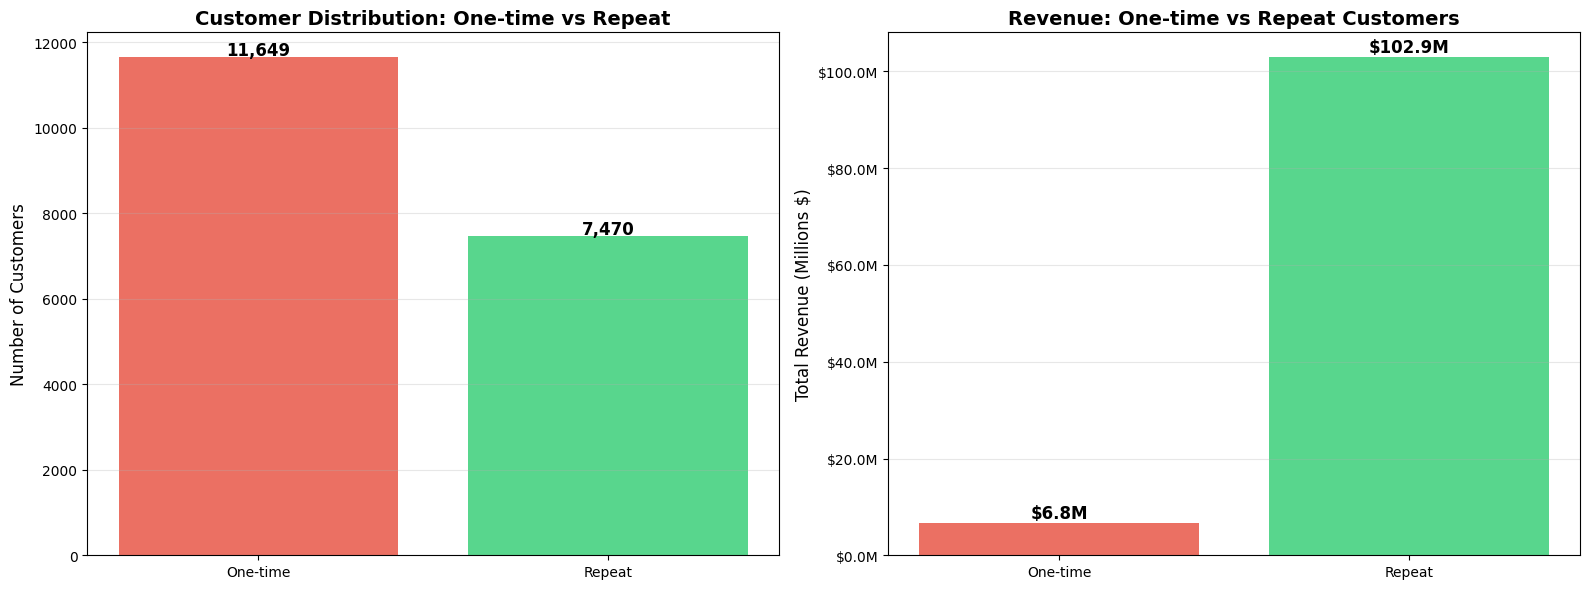


=== KEY INSIGHTS ===
Retention Rate: 39.1%
Repeat Customers: 7,470 out of 19,119 total
Repeat customers generate 93.8% of total revenue

Average revenue per customer type:
  One-time: $581.18
  Repeat: $13,779.72


In [7]:
# Visualize customer retention
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Customer count: One-time vs Repeat
colors = ['#e74c3c', '#2ecc71']
ax1.bar(retention_summary_pd['CustomerType'], retention_summary_pd['CustomerCount'], color=colors, alpha=0.8)
ax1.set_ylabel('Number of Customers', fontsize=12)
ax1.set_title('Customer Distribution: One-time vs Repeat', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (ctype, count) in enumerate(zip(retention_summary_pd['CustomerType'], retention_summary_pd['CustomerCount'])):
    ax1.text(i, count + 50, f'{count:,.0f}', ha='center', fontsize=12, fontweight='bold')

# Revenue by customer type
ax2.bar(retention_summary_pd['CustomerType'], retention_summary_pd['TotalRevenue'] / 1_000_000, color=colors, alpha=0.8)
ax2.set_ylabel('Total Revenue (Millions $)', fontsize=12)
ax2.set_title('Revenue: One-time vs Repeat Customers', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.1f}M'))

# Add revenue labels
for i, (ctype, rev) in enumerate(zip(retention_summary_pd['CustomerType'], retention_summary_pd['TotalRevenue'])):
    ax2.text(i, (rev / 1_000_000) + 1, f'${rev/1_000_000:.1f}M', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Key insights
retention_rate = retention_rate_pd[retention_rate_pd['Metric'] == 'Retention Rate']['Value'].values[0]
repeat_customers = retention_rate_pd[retention_rate_pd['Metric'] == 'Repeat Customers']['Value'].values[0]
total_customers = retention_rate_pd[retention_rate_pd['Metric'] == 'Total Customers']['Value'].values[0]

repeat_revenue = retention_summary_pd[retention_summary_pd['CustomerType'] == 'Repeat']['TotalRevenue'].values[0]
total_revenue = retention_summary_pd['TotalRevenue'].sum()
repeat_revenue_pct = (repeat_revenue / total_revenue) * 100

print("\n=== KEY INSIGHTS ===")
print(f"Retention Rate: {retention_rate:.1f}%")
print(f"Repeat Customers: {repeat_customers:,.0f} out of {total_customers:,.0f} total")
print(f"Repeat customers generate {repeat_revenue_pct:.1f}% of total revenue")
print(f"\nAverage revenue per customer type:")
for _, row in retention_summary_pd.iterrows():
    print(f"  {row['CustomerType']}: ${row['AvgRevenue']:,.2f}")

In [8]:
# Stop Spark
spark.stop()
print("Analysis complete!")

Analysis complete!
